# Tweets and Flair

This is an analysis using twitter data scraped during the coronavirus, and will be taking a look at how the tweets in the US changed over time.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

from mention_2_hashtag import * 
from scripts import *

FIN = 'flair_joined_tweets.csv'

raw = pd.read_csv(FIN)

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

# changing na to None
raw = raw.fillna('None')

# only 4 samples that have no sentiment
raw = raw[raw['sentiment'] != 'None']

raw.head()

,created_at,place,ogtext,cleantext,mentions,hashtags,pos,ner,sentiment,date,time,hour
0,2020-02-10 07:03:44+00:00,"Paradise, NV",having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,None,None,"[['having', 'VBG'], ['a', 'DT'], ['mocha', 'NN...",None,POSITIVE,2020-02-10,07:03:44,7
1,2020-02-10 07:04:49+00:00,"Queens, NY",our hearts beat with china,heart beat china,['linsapna'],None,"[['our', 'PRP$'], ['hearts', 'NNS'], ['beat', ...",None,POSITIVE,2020-02-10,07:04:49,7
2,2020-02-10 07:05:30+00:00,"Tempe, AZ",people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,None,None,"[['people', 'NNS'], ['stop', 'VBP'], ['my', 'P...",None,POSITIVE,2020-02-10,07:05:30,7
3,2020-02-10 07:10:48+00:00,"Arkansas, USA",coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,None,None,"[['coronavirus', 'NN'], ['death', 'NN'], ['tol...",None,NEGATIVE,2020-02-10,07:10:48,7
4,2020-02-10 07:11:11+00:00,"Arkansas, USA",coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,None,None,"[['coronavirus', 'NN'], ['cases', 'NNS'], ['ab...",None,NEGATIVE,2020-02-10,07:11:11,7


Here is the head of the data, as we can see the part of speech includes each word and POS tag from flair. Also, not every tweet has a named entity. The date, time, and hour of the tweet posted are also seperated from the 'created_at' column.

## Info on data

Lets try and get a feel for what all this data includes.

In [3]:
print('Shape of data:', raw.shape)
print('# of Unique places:',len(raw['place'].unique()))
print('first recorded tweet:', raw['date'].min())
print('last recorded tweet:', raw['date'].max())

Shape of data: (308099, 12)
# of Unique places: 13134
first recorded tweet: 2020-01-22
last recorded tweet: 2020-06-06


Lets dive in:

* As we can see there are ~153k tweets over the course of 2 months, all from the United States of America.
* There are a total of 9428 unique places which means this data is messy and will take some creativity to clean up.
* The tweets start on Janurary 22, 2020 and end on March 21, 2020.

# Basic Overview

Lets take a look at some of the words being tweeted

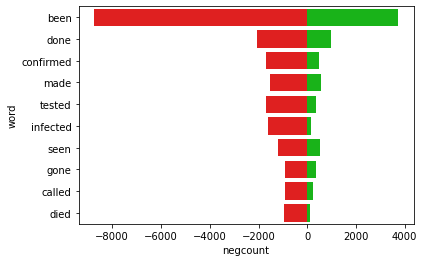

In [139]:
# # count words in dataframe
# df = text_lister(raw['cleantext'])
# df = count_words(df)
# # df.head(10)

# search for words by pos tags
# VBG ?
poslist = filter_pos(raw[raw['sentiment'] == 'POSITIVE']['pos'], 'VBN')
neglist = filter_pos(raw[raw['sentiment'] == 'NEGATIVE']['pos'], 'VBN')

# verbdf = count_n_seperate(poslist, neglist, 10) 

posdf = count_words(poslist)
negdf = count_words(neglist)
# posdf.head(10)
negdf['count'] = negdf['count'] * -1
verbdf = posdf.merge(negdf, on='word')
verbdf['sum'] = verbdf['count_x'] + ( verbdf['count_y'] * -1 )
verbdf.columns = ['word', 'poscount', 'negcount', 'sum']
verbdf = verbdf.nlargest(10, 'sum')

p1 = sns.barplot(data=verbdf, x='poscount', y='word', palette= ['#00cc00'])
p1 = sns.barplot(data=verbdf, x='negcount', y='word', palette= ['#ff0000'])

# Number of tweets over time

Lets take a look at the number of tweets by Sentinent Value over the course of the data.

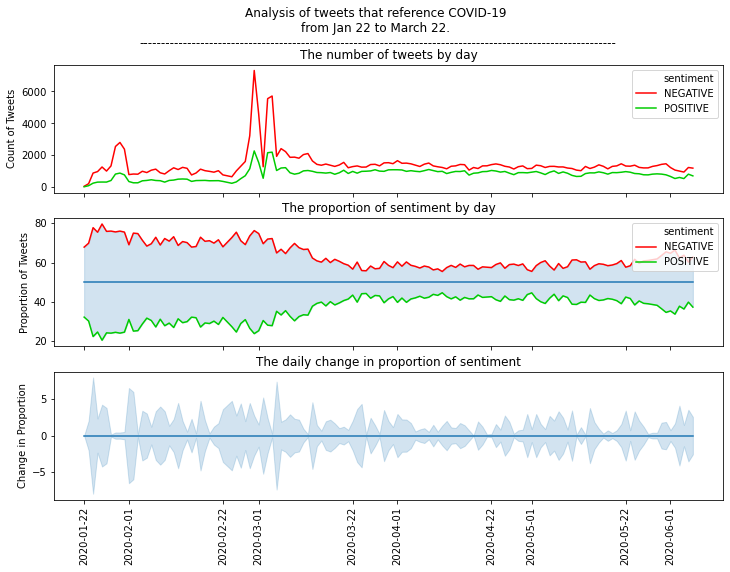

In [136]:
ntweetdf, propdf = ntweet_prop_dfs(raw, 'date', 'sentiment')


# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19 \nfrom Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= ntweetdf, x= 'date', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax= ax[0])
plot = plot.set_title("The number of tweets by day")
plot = plt.xticks(rotation=60)
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= propdf, x= 'date', y="proportion", ax= ax[1])
p1 = sns.lineplot(data= propdf, x= 'date', y="proportion", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1]).set_title("The proportion of sentiment by day")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= propdf, x= 'date', y="difference", ax= ax[2]).set_title("The daily change in proportion of sentiment")
ax[2].set(ylabel='Change in Proportion')

# plot shared x axis
plot = plt.xlabel("")
plot = plt.xticks(rotation=90)

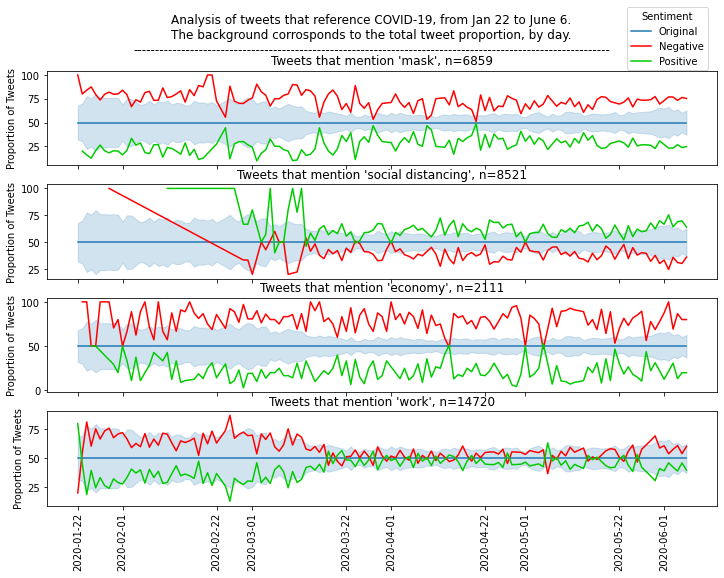

In [135]:
# adds columns for phrases
phraselist = ['mask', "social distancing", "economy", "work"]
phrasedf = search_phrases(raw, phraselist)

rawntweetdf, rawpropdf = ntweet_prop_dfs(raw, 'date', 'sentiment')

dates = pd.date_range(raw['date'].min(), raw['date'].max(), freq='D')

# plotting ##########

# do fill bar graphs

fig, ax = plt.subplots(nrows=len(phraselist), ncols=1, figsize=(12, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19, from Jan 22 to June 6.\nThe background corrosponds to the total tweet proportion, by day.\n-------------------------------------------------------------------------------------------------------------')

for i, phrase in enumerate(phraselist):
    pcol = ".".join(phrase.split(' '))
    pcol = f'in.{pcol}'

    ntweets = len(phrasedf[phrasedf[pcol] == 1].index)

    ntweetdf, propdf = ntweet_prop_dfs(phrasedf[phrasedf[pcol] == 1], 'date', 'sentiment')

    # base plot
    base = sns.lineplot(data= rawpropdf, x= 'date', y="proportion", ax= ax[i], legend=False).set_title("The proportion of sentiment by day")
    ax[i].set(ylabel='Proportion of Tweets')
    
    # # trying to give linebreaks for missing dates
    # pos = propdf[propdf['sentiment'] == 'POSITIVE']
    # pos = pos.reindex(dates)
    # overlay = sns.lineplot(data= pos, x= 'date', y="proportion", palette= ['#ff0000', '#00cc00'], hue='sentiment', ax= ax[i], legend=False)

    # neg = propdf[propdf['sentiment'] == 'POSITIVE']
    # neg = neg.reindex(dates)
    # overlay = sns.lineplot(data=neg, x= 'date', y="proportion", palette= ['#ff0000']*sum(neg["sentiment"].isna()), hue= neg['sentiment'].isna().cumsum(), ax= ax[i], legend=False).set_title(f"Tweets that mention '{phrase}', n={ntweets}")
    # # 

    overlay = sns.lineplot(data= propdf, x= 'date', y="proportion", palette= ['#ff0000', '#00cc00'], hue='sentiment', ax= ax[i], legend=False).set_title(f"Tweets that mention '{phrase}', n={ntweets}")
    ax[i].set(ylabel='Proportion of Tweets')


# plot shared x axis
plot = plt.xlabel("")
plot = plt.xticks(rotation=90)
fig.legend([0,1,2], labels=["Original", "Negative", "Positive"], bbox_to_anchor=(0.825,1.0), loc=1, title="Sentiment")




The second graph shows the proportion of sentiment each day, getting closer to 50% overtime. This also describes the probability that a tweet is positive or negative on any given day.

The third graph shows the daily changes in proportion, or how volatile the tweets are. With the biggest change nearing __%.

Here is what this all means in terms of math.

$ A^{(j)} = \textit{ The event that } 
\left\{
    \begin{array}{ll}
        A^{(0)}  & \mbox{if sentiment is } negative  \\
        A^{(1)} & \mbox{if sentiment is } positive
    \end{array}
\right. | \mbox{ } A \subset tweets, \mbox{ } j \in \mathbb{Z}_2 $

$ B_n = \textit{ The event that a tweet occurs on } day_0, \mbox{ } ..., \mbox{ } day_n 
\mbox{ } | \mbox{ } \forall \textit{ days } \exists  \textit{ n, st. n} \in \mathbb{Z}_{ \textit{ max(days)} } $

<br />

$ P(A^{(j)}|B_n) = 
\left\{
    \begin{array}{ll}
        P(A^{(0)}|day_n) = 100 \bullet ( \frac{ A^{(0)} } { A^{(0)}+A^{(1)} } ) \\
        P(A^{(1)}|day_n) = 100 \bullet ( \frac{ A^{(1)} } { A^{(1)}+A^{(0)} } )
    \end{array}
\right. $

$ \frac{d} {dB} P(A^{(j)}|B_n) = P(A^{(j)}|day_{n-1}) - P(A^{(j)}|day_{n}) \mbox{ }_\blacksquare $




## Number of Tweets Over a Day

Now lets take a at what the tweet distribution is over the course of any given 24 hour day.

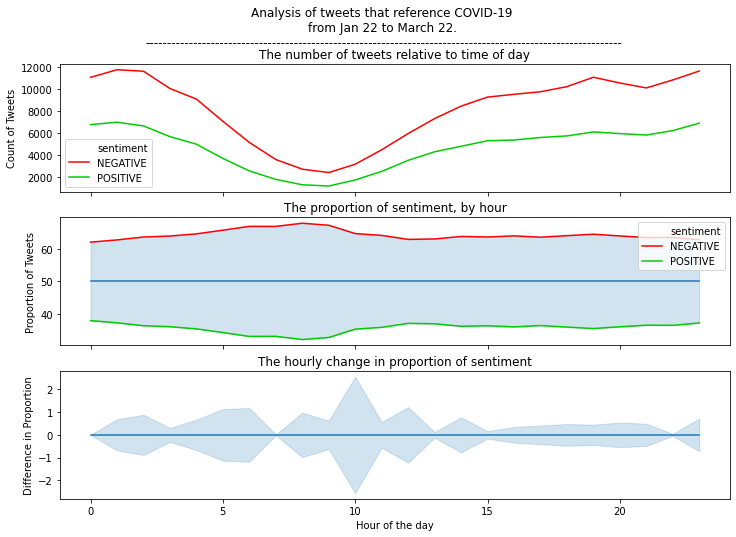

In [137]:
ntweetdf, propdf = ntweet_prop_dfs(raw, 'hour', 'sentiment')

# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19 \nfrom Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= ntweetdf, x= 'hour', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax=ax[0])
plot = plot.set_title("The number of tweets relative to time of day")
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= propdf, x= 'hour', y="proportion", ax= ax[1])
p1 = sns.lineplot(data= propdf, x= 'hour', y="proportion", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1]).set_title("The proportion of sentiment, by hour")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= propdf, x= 'hour', y="difference", ax= ax[2]).set_title("The hourly change in proportion of sentiment")
ax[2].set(ylabel='Difference in Proportion')

# plot shared x axis
plot = plt.xlabel("Hour of the day")

These graphs describe the same as last time, however it is modified for the time of day the tweet was posted, rather than the day itself.

As shown there seems to be a large dip from hour __ to hour __. This suggests that a lot of people are not tweeting about COVID-19 from __ to __.

However, the proportion of positive and negative sentiment tweets is very stable throughout the day, with the highest change being around __%. Again, this also describes the probability of any given tweet for any hour of the day.

Here is what this means in math.

$ A^{(j)} = 
\left\{
    \begin{array}{ll}
        A^{(0)}  & \mbox{if sentiment is } negative  \\
        A^{(1)} & \mbox{if sentiment is } positive
    \end{array}
\right. | \mbox{ } A \subset tweets, \mbox{ } j \in \mathbb{Z}_2 $

$ B_n = \textit{ The event that a tweet occurs on } hour_0, \mbox{ } ..., \mbox{ } hour_n 
\mbox{ } | \mbox{ } \forall \textit{ hours } \exists  \textit{ n, st. n} \in \mathbb{Z}_{ 24 } $

<br />

$ P(A^{(j)}|B_n) = 
\left\{
    \begin{array}{ll}
        P(A^{(0)}|hour_n) = 100 \bullet ( \frac{ A^{(0)} } { A^{(0)}+A^{(1)} } ) \\
        P(A^{(1)}|hour_n) = 100 \bullet ( \frac{ A^{(1)} } { A^{(1)}+A^{(0)} } )
    \end{array}
\right. $

$ \frac{d} {dB} P(A^{(j)}|B_n) = P(A^{(j)}|day_{n-1}) - P(A^{(j)}|day_{n}) \mbox{ }_\blacksquare $



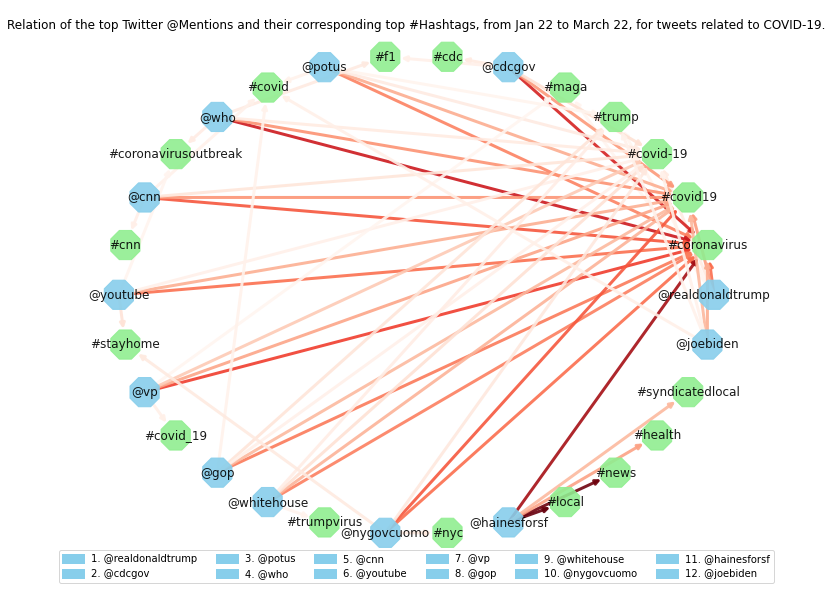

In [10]:
Nmentions = 12
Nhashtags = 5

data = get_mentions_hashtags(raw, Nmentions, Nhashtags)

data = data.replace('covidー19', 'covid-19')

data['mention'] = '@' + data['mention']
data['hashtag'] = '#' + data['hashtag']

nodes = data['mention'].unique()

G=nx.from_pandas_edgelist(data, 'mention', 'hashtag', create_using=nx.DiGraph())

plt.figure(figsize=(10,8))

color_map = []
for node in G:
    if node in nodes:
        color_map.append('skyblue')
    else: 
        color_map.append('lightgreen')

nx.draw_circular(G, with_labels=True, node_size=1000, alpha=0.9, arrows=True, edge_color=data['proportion'], width=3.0, edge_cmap=plt.cm.Reds, node_color=color_map, node_shape="8")
plt.suptitle("Relation of the top Twitter @Mentions and their corresponding top #Hashtags, from Jan 22 to March 22, for tweets related to COVID-19.")

labs = [str(i+1) + '. ' for i in range(Nmentions)] + data['mention'].unique()

leg = plt.legend(labs, loc='lower center', ncol=6, frameon=True, borderaxespad= 0)
#leg.set_title('Ranking of Mentions')
for i in range(Nmentions):
    leg.legendHandles[i].set_color('skyblue')

plt.show()

This graph shows the relation of mentions to hashtags.

From this we can see that almost every mention had a top hashtag of '#coranavirus'.

In [11]:
data

,mention,hashtag,count,proportion
0,@realdonaldtrump,#coronavirus,789,0.106205
1,@realdonaldtrump,#covid19,573,0.077130
2,@realdonaldtrump,#covid-19,172,0.023153
3,@realdonaldtrump,#trump,97,0.013057
4,@realdonaldtrump,#maga,89,0.011980
5,@cdcgov,#coronavirus,232,0.148718
6,@cdcgov,#covid19,124,0.079487
7,@cdcgov,#covid-19,53,0.033974
8,@cdcgov,#cdc,36,0.023077
9,@cdcgov,#f1,26,0.016667


## Questions to answer

time is in universal timezone, will need to be changed!!

* places are being done already?

Barchart of verbs and ner. wordcloud?? adjectives?

* maybe wordcloud?

anything in particular, trump sentiment? china sentiment? masks? ect.

* look into this via timeline

get states and cities, barchart top states, sentiment by state?

* places are being done

get dates for major reform? correlation to number of tests, number of cases, deaths?

* good longterm idea for NN

## Things to add

FINAL DATASET ADDS

* timezone
    + set to UTC, must manually change
    + also add hour modifications as column based on timezone

* corrected place
    + state, city, county, ect
    
* extra data
    + timezone
    + hour modifications
    + dates of political reform?
    + number of tests /day?
    + number of cases/deaths?
    + socioeconomic data for locations